Imports

In [1]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Create Classes

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

Primitives and Toolbox

In [3]:
random.seed(0)

def identity(x):
    return x

pset = gp.PrimitiveSetTyped("MAIN", in_types=[float, float, float, float, float, float, float], ret_type=bool)
pset.addPrimitive(np.less, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.logical_not, in_types=[bool], ret_type=bool)
pset.addPrimitive(np.logical_and, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_or, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(identity, in_types=[float], ret_type=float)
pset.addEphemeralConstant("float_const", ephemeral=lambda: random.randint(0, 100), ret_type=float)
pset.addEphemeralConstant("bool_const", ephemeral=lambda: random.randint(0, 1), ret_type=bool)

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

Data

In [4]:
# Load data into numpy array (numeric data only)
sex = lambda x: 0.0 if x == b"male" else 1.0  # male = 0, female = 1
embarked = lambda x: 0.0 if x == b'C' else 2.0 if x == b'Q' else 1.0 # C = 0, S = 1, Q = 2; fill missing embarked values with S
data = np.genfromtxt(open("../data/train.csv"), delimiter=',', skip_header=1, usecols=(1, 2, 5, 6, 7, 8, 10, 12), converters={5: sex, 12: embarked})

# Fill missing age and fare (testing data only) values with averages for each class
def fill_missing(data):
    class1 = data[:, 0] == 1
    class2 = data[:, 0] == 2
    class3 = data[:, 0] == 3

    avg_age1 = np.nanmean(data[class1, 2])
    avg_age2 = np.nanmean(data[class2, 2])
    avg_age3 = np.nanmean(data[class3, 2])
    avg_fare1 = np.nanmean(data[class1, 5])
    avg_fare2 = np.nanmean(data[class2, 5])
    avg_fare3 = np.nanmean(data[class3, 5])

    age_nans = np.isnan(data[:, 2])
    fare_nans = np.isnan(data[:, 5])

    data[age_nans & class1, 2] = avg_age1
    data[age_nans & class2, 2] = avg_age2
    data[age_nans & class3, 2] = avg_age3
    data[fare_nans & class1, 5] = avg_fare1
    data[fare_nans & class2, 5] = avg_fare2
    data[fare_nans & class3, 5] = avg_fare3

X = data[:, 1:]
y = data[:, 0]
fill_missing(X)

Evaluation Function

In [5]:
def evalClassif(individual, examples, labels, pset):
    func = gp.compile(expr=individual, pset=pset)
    preds = func(*examples.T)

    return (np.sum((preds == 1) & (labels == 0)), np.sum((preds == 0) & (labels == 1)))

toolbox.register("evaluate", evalClassif, examples=X, labels=y, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Main Algorithm

In [6]:
NGEN = 250
MU = 500
LAMBDA = 1000
CXPB = 0.2
MUTPB = 0.5

# Wrapper for AUC calculation per generation
class ParetoFrontAUC(tools.ParetoFront):
    def __init__(self):
        super().__init__()
        self.aucs = []
    
    def update(self, pop):
        super().update(pop)
        fitness_1 = [ind.fitness.values[0] for ind in self]
        fitness_2 = [ind.fitness.values[1] for ind in self]
        auc = np.sum(np.abs(np.diff(fitness_1))*fitness_2[:-1])
        self.aucs.append(auc)

pop = toolbox.population(n=MU)
hof = ParetoFrontAUC()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

gen	nevals	avg              	std                        	min    	max        
0  	500   	[218.846 205.29 ]	[253.4849942  152.25367615]	[0. 0.]	[549. 342.]
1  	689   	[ 31.754 320.89 ]	[114.35464785  67.64618171]	[0. 0.]	[549. 342.]
2  	697   	[  0.856 340.578]	[15.61048571 10.34658958]  	[  0. 179.]	[347. 342.]
3  	698   	[1.24000e-01 3.40788e+02]	[1.8784632  3.78510977]    	[  0. 280.]	[ 39. 342.]
4  	715   	[7.8000e-02 3.4019e+02]  	[1.74238802 3.1083597 ]    	[  0. 280.]	[ 39. 342.]
5  	694   	[  0.864 339.308]        	[18.36947207  6.27225127]  	[  0. 235.]	[411. 342.]
6  	678   	[3.20000e-01 3.38662e+02]	[ 6.20528807 10.47070943]  	[  0. 107.]	[138. 342.]
7  	720   	[  1.164 337.746]        	[24.537178   15.90715198]  	[0. 0.]    	[549. 342.]
8  	665   	[  1.916 337.374]        	[30.08828583 16.8617355 ]  	[0. 0.]    	[549. 342.]
9  	722   	[1.38000e-01 3.37982e+02]	[1.81960325 6.0548886 ]    	[  0. 205.]	[ 37. 342.]
10 	713   	[3.02000e-01 3.37838e+02]	[4.74961009 7.29409048]    	

93 	708   	[  0.936 334.864]        	[19.88788335 10.21006876]  	[  0. 109.]	[445. 342.]
94 	724   	[1.78000e-01 3.35178e+02]	[3.37850795 4.10198927]    	[  0. 249.]	[ 75. 342.]
95 	706   	[6.00000e-02 3.35326e+02]	[0.78511146 1.458672  ]    	[  0. 329.]	[ 14. 342.]
96 	711   	[7.4000e-02 3.3551e+02]  	[0.82735966 1.80385698]    	[  0. 332.]	[ 14. 342.]
97 	702   	[  2.268 334.01 ]        	[30.46381749 17.87629436]  	[ 0. 12.]  	[547. 342.]
98 	718   	[2.2600e-01 3.3523e+02]  	[3.42153825 4.23333202]    	[  0. 249.]	[ 75. 342.]
99 	712   	[8.20000e-02 3.35506e+02]	[0.74247963 1.86493003]    	[  0. 329.]	[  8. 342.]
100	729   	[  1.022 334.998]        	[19.93994774 10.38643327]  	[  0. 109.]	[445. 342.]
101	700   	[4.40000e-02 3.35326e+02]	[0.71976663 1.46277955]    	[  0. 329.]	[ 14. 342.]
102	702   	[1.7200e-01 3.3525e+02]  	[3.3797065  4.24917639]    	[  0. 249.]	[ 75. 342.]
103	723   	[  1.746 334.568]        	[26.65335784 13.68390938]  	[  0. 109.]	[445. 342.]
104	703   	[  0.364 3

187	725   	[  0.    265.962]        	[0.        4.9711725]      	[  0. 265.]	[  0. 339.]
188	683   	[2.00000e-03 2.65452e+02]	[0.04467662 3.66711003]    	[  0. 264.]	[  1. 342.]
189	676   	[1.12000e-01 2.65266e+02]	[1.93480128 6.0142534 ]    	[  0. 189.]	[ 41. 342.]
190	696   	[2.80000e-02 2.65196e+02]	[0.62547262 3.45276469]    	[  0. 249.]	[ 14. 340.]
191	705   	[2.48000e-01 2.65132e+02]	[2.94660754 7.46930894]    	[  0. 189.]	[ 41. 342.]
192	709   	[3.00000e-02 2.65152e+02]	[0.62697687 3.56046289]    	[  0. 248.]	[ 14. 342.]
193	700   	[1.18000e-01 2.65082e+02]	[1.93289317 5.87156504]    	[  0. 189.]	[ 41. 340.]
194	698   	[8.20000e-02 2.64966e+02]	[1.83174125 4.86465251]    	[  0. 189.]	[ 41. 342.]
195	680   	[1.00000e-02 2.65044e+02]	[0.22338308 3.39677259]    	[  0. 256.]	[  5. 339.]
196	709   	[  0.    264.976]        	[0.         3.65286518]    	[  0. 263.]	[  0. 342.]
197	713   	[1.6800e-01 2.6435e+02]  	[2.58839255 5.24819016]    	[  0. 189.]	[ 41. 307.]
198	724   	[6.60000e-

Plots (Baseline)

Best individual is: logical_and(greater(Sex, Parch), logical_or(logical_or(logical_or(equal(identity(identity(Parch)), Pclass), logical_or(logical_or(logical_or(logical_or(logical_or(equal(Embarked, Pclass), logical_or(equal(Age, 15), 0)), equal(identity(identity(16)), identity(Age))), 0), logical_or(logical_or(logical_or(logical_or(logical_or(logical_or(logical_or(logical_or(equal(Embarked, Pclass), logical_or(equal(Age, identity(13)), greater(Fare, Age))), equal(identity(identity(16)), identity(Age))), 0), greater(identity(Fare), Age)), logical_or(equal(SibSp, Pclass), logical_or(logical_or(greater(identity(Age), identity(58)), logical_or(equal(Embarked, identity(identity(Pclass))), greater(identity(Fare), Age))), equal(identity(identity(Pclass)), identity(Age))))), equal(identity(29), identity(Age))), equal(identity(identity(16)), identity(Age))), logical_or(logical_or(logical_or(equal(Embarked, identity(Age)), logical_not(1)), logical_or(logical_or(logical_or(equal(Embarked, identi

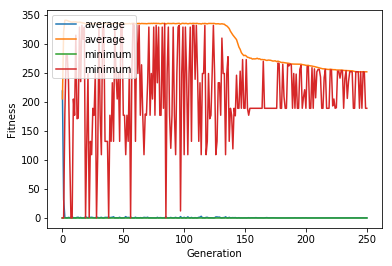

In [7]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

Praeto Front (Baseline)

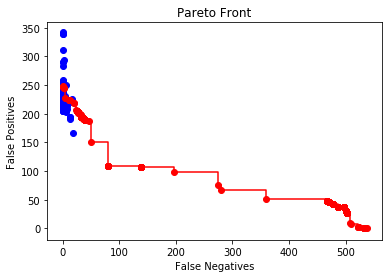

Area Under Curve: 48423.0


In [10]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

Modified GP (change this)

In [8]:
random.seed(0)

creator.create("FitnessMin2", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual2", gp.PrimitiveTree, fitness=creator.FitnessMin2)

def identity(x):
    return x

pset = gp.PrimitiveSetTyped("MAIN", in_types=[float, float, float, float, float, float, float], ret_type=bool)
pset.addPrimitive(np.less, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.logical_not, in_types=[bool], ret_type=bool)
pset.addPrimitive(np.logical_and, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_or, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(identity, in_types=[float], ret_type=float)

pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)

pset.addEphemeralConstant("float_const2", ephemeral=lambda: random.randint(0, 100), ret_type=float)
pset.addEphemeralConstant("bool_const2", ephemeral=lambda: random.randint(0, 1), ret_type=bool)

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual2, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalClassif(individual, examples, labels, pset):
    func = gp.compile(expr=individual, pset=pset)
    preds = func(*examples.T)

    return (np.sum((preds == 1) & (labels == 0)), np.sum((preds == 0) & (labels == 1)))

toolbox.register("evaluate", evalClassif, examples=X, labels=y, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))



NGEN = 250
MU = 500
LAMBDA = 2000
CXPB = 0.4
MUTPB = 0.6

pop = toolbox.population(n=MU)
hof2 = ParetoFrontAUC()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof2)

gen	nevals	avg              	std                        	min    	max        
0  	500   	[226.236 200.386]	[257.97623981 155.60190553]	[0. 0.]	[549. 342.]
1  	2000  	[ 36.072 317.332]	[118.82556466  71.82271073]	[0. 0.]	[549. 342.]
2  	2000  	[  3.752 338.74 ]	[36.01081082 20.52872134]  	[ 0. 73.]	[464. 342.]
3  	2000  	[  2.564 339.506]	[34.04376454 22.01058754]  	[0. 0.]  	[549. 342.]
4  	2000  	[  4.174 338.766]	[44.10224171 26.39218149]  	[0. 0.]  	[549. 342.]
5  	2000  	[  0.88 341.07]  	[18.38710418  5.55491674]  	[  0. 235.]	[411. 342.]
6  	2000  	[4.20000e-02 3.41326e+02]	[0.68134866 1.63209191]    	[  0. 332.]	[ 14. 342.]
7  	2000  	[  2.452 339.444]        	[33.47362687 22.27489313]  	[0. 1.]    	[535. 342.]
8  	2000  	[7.80000e-02 3.41174e+02]	[0.9715534  1.72154698]    	[  0. 326.]	[ 14. 342.]
9  	2000  	[  0.424 340.352]        	[7.3468513  8.08629062]    	[  0. 170.]	[159. 342.]
10 	2000  	[  1.088 339.884]        	[24.17015217 14.68354671]  	[ 0. 16.]  	[541. 342.]
11 	20

92 	2000  	[1.4600e-01 2.4271e+02]  	[ 1.15960511 18.97287274]  	[  0. 209.]	[ 22. 342.]
93 	2000  	[1.62000e-01 2.40502e+02]	[ 2.05323063 13.93305408]  	[  0. 196.]	[ 44. 342.]
94 	2000  	[  0.292 239.652]        	[ 2.92074237 13.4214342 ]  	[  0. 190.]	[ 52. 342.]
95 	2000  	[  0.432 238.374]        	[ 3.63502077 10.04122124]  	[  0. 202.]	[ 56. 329.]
96 	2000  	[1.16000e-01 2.38846e+02]	[ 1.09660567 14.43462102]  	[  0. 191.]	[ 21. 342.]
97 	2000  	[  0.244 236.838]        	[ 2.52358158 10.36126228]  	[  0. 161.]	[ 41. 342.]
98 	2000  	[  0.45  236.032]        	[ 3.63531292 11.80097352]  	[  0. 153.]	[ 50. 342.]
99 	2000  	[  0.436 235.598]        	[3.08899725 7.76842301]    	[  0. 188.]	[ 48. 338.]
100	2000  	[1.68000e-01 2.35222e+02]	[1.28832294 7.91332522]    	[  0. 202.]	[ 17. 338.]
101	2000  	[  0.26  237.834]        	[ 1.89113722 16.36845882]  	[  0. 212.]	[ 23. 342.]
102	2000  	[  0.548 235.538]        	[ 3.94812563 12.44606588]  	[  0. 151.]	[ 46. 342.]
103	2000  	[  0.536 2

185	2000  	[1.46000e-01 2.25408e+02]	[ 1.01621061 12.94440172]  	[  0. 203.]	[ 13. 342.]
186	2000  	[  0.334 223.978]        	[2.02446141 6.6085941 ]    	[  0. 186.]	[ 25. 288.]
187	2000  	[  0.334 224.862]        	[2.27913229 9.48466953]    	[  0. 196.]	[ 36. 339.]
188	2000  	[  0.39  225.034]        	[ 2.58493714 10.805223  ]  	[  0. 186.]	[ 27. 342.]
189	2000  	[  0.552 224.336]        	[ 3.91040867 12.25524802]  	[  0. 131.]	[ 64. 338.]
190	2000  	[  0.324 224.392]        	[ 2.02657938 10.57952437]  	[  0. 198.]	[ 25. 342.]
191	2000  	[1.58000e-01 2.24246e+02]	[1.15110208 9.26895269]    	[  0. 209.]	[ 16. 338.]
192	2000  	[1.90000e-01 2.23728e+02]	[1.47577098 8.70115027]    	[  0. 206.]	[ 27. 339.]
193	2000  	[  0.384 223.222]        	[ 3.0738484  11.54576615]  	[  0. 139.]	[ 53. 342.]
194	2000  	[  0.23  223.534]        	[ 1.68792772 13.02170665]  	[  0. 203.]	[ 27. 342.]
195	2000  	[  0.742 222.524]        	[13.60791814 12.47739652]  	[ 0. 90.]  	[304. 342.]
196	2000  	[  0.38  2

Plots (Modified)

Best individual is: less(add(sub(sub(21, mul(Fare, Sex)), add(identity(add(mul(add(sub(mul(sub(sub(Pclass, mul(sub(Sex, Sex), mul(add(identity(Parch), sub(27, Fare)), identity(sub(Embarked, Age))))), mul(sub(SibSp, Pclass), SibSp)), Embarked), add(sub(SibSp, add(add(Pclass, mul(Sex, Embarked)), add(Age, Parch))), Sex)), identity(add(mul(sub(Embarked, sub(mul(sub(mul(12, Parch), add(Sex, add(Age, Parch))), sub(Parch, Parch)), Sex)), sub(add(Embarked, Embarked), SibSp)), Parch))), mul(Sex, Parch)), Sex)), mul(identity(identity(Sex)), sub(identity(add(mul(sub(mul(sub(sub(SibSp, SibSp), sub(sub(Sex, Fare), Embarked)), sub(SibSp, SibSp)), Age), sub(SibSp, Embarked)), Parch)), identity(add(mul(sub(Parch, Parch), sub(add(43, add(mul(sub(mul(Sex, Parch), identity(25)), sub(identity(SibSp), sub(Fare, Pclass))), Age)), add(add(Pclass, SibSp), add(SibSp, Embarked)))), sub(21, Fare))))))), add(mul(sub(SibSp, Pclass), add(Embarked, Embarked)), mul(Age, Pclass))), add(mul(sub(Sex, identity(mul(Embar

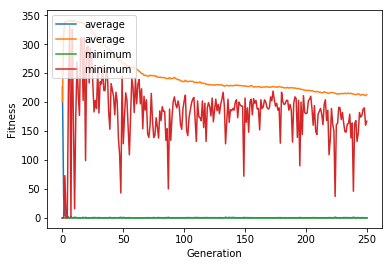

In [9]:
print("Best individual is: %s\nwith fitness: %s" % (hof2[0], hof2[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

Praeto Front (Modified)

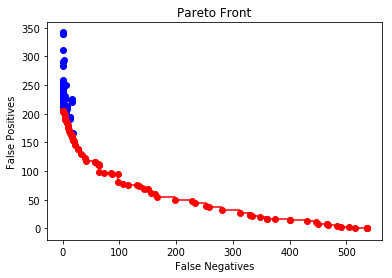

Area Under Curve: 26617.0


In [11]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof2]
fitness_2 = [ind.fitness.values[1] for ind in hof2]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

AUC Graph

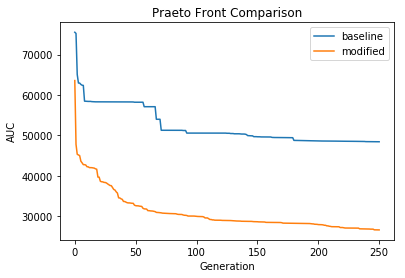

In [12]:
gen = logbook.select("gen")
plt.plot(gen, hof.aucs, label="baseline")
plt.plot(gen, hof2.aucs, label="modified")
plt.legend(loc="upper right")
plt.xlabel("Generation")
plt.ylabel("AUC")
plt.title("Praeto Front Comparison")
plt.show()